# Assignment 2

In this assigment, we will work with the *Forest Fire* data set. Please download the data from the [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/162/forest+fires). Extract the data files into the subdirectory: `../data/fires/` (relative to `./05_src/`).

## Objective

+ The model objective is to predict the area affected by forest fires given the features set. 
+ The objective of this exercise is to assess your ability to construct and evaluate model pipelines.
+ Please note: the instructions are not meant to be 100% prescriptive, but instead they are a set of minimum requirements. If you find predictive performance gains by applying additional steps, by all means show them. 

## Variable Description

From the description file contained in the archive (`forestfires.names`), we obtain the following variable descriptions:

1. X - x-axis spatial coordinate within the Montesinho park map: 1 to 9
2. Y - y-axis spatial coordinate within the Montesinho park map: 2 to 9
3. month - month of the year: "jan" to "dec" 
4. day - day of the week: "mon" to "sun"
5. FFMC - FFMC index from the FWI system: 18.7 to 96.20
6. DMC - DMC index from the FWI system: 1.1 to 291.3 
7. DC - DC index from the FWI system: 7.9 to 860.6 
8. ISI - ISI index from the FWI system: 0.0 to 56.10
9. temp - temperature in Celsius degrees: 2.2 to 33.30
10. RH - relative humidity in %: 15.0 to 100
11. wind - wind speed in km/h: 0.40 to 9.40 
12. rain - outside rain in mm/m2 : 0.0 to 6.4 
13. area - the burned area of the forest (in ha): 0.00 to 1090.84 









### Specific Tasks

+ Construct four model pipelines, out of combinations of the following components:

    + Preprocessors:

        - A simple processor that only scales numeric variables and recodes categorical variables.
        - A transformation preprocessor that scales numeric variables and applies a non-linear transformation.
    
    + Regressor:

        - A baseline regressor, which could be a [K-nearest neighbours model]() or a linear model like [Lasso](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.Lasso.html) or [Ridge Regressors](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.ridge_regression.html).
        - An advanced regressor of your choice (e.g., Bagging, Boosting, SVR, etc.). TIP: select a tree-based method such that it does not take too long to run SHAP further below. 

+ Evaluate tune and evaluate each of the four model pipelines. 

    - Select a [performance metric](https://scikit-learn.org/stable/modules/linear_model.html) out of the following options: explained variance, max error, root mean squared error (RMSE), mean absolute error (MAE), r-squared.
    - *TIPS*: 
    
        * Out of the suggested metrics above, [some are correlation metrics, but this is a prediction problem](https://www.tmwr.org/performance#performance). Choose wisely (and don't choose the incorrect options.) 

+ Select the best-performing model and explain its predictions.

    - Provide local explanations.
    - Obtain global explanations and recommend a variable selection strategy.

+ Export your model as a pickle file.


You can work on the Jupyter notebook, as this experiment is fairly short (no need to use sacred). 

# Load the data

Place the files in the ../../05_src/data/fires/ directory and load the appropriate file. 

In [6]:
# Load the libraries as required.
%load_ext dotenv
%dotenv
import os
import sys
sys.path.append(os.getenv('SRC_DIR'))
import pandas as pd
import numpy as np


# Load data
fire_file = os.getenv("FIRES_DATA")
df_fire = pd.read_csv(fire_file)

The dotenv extension is already loaded. To reload it, use:
  %reload_ext dotenv


In [8]:
# checking for myself: to see what path I am on and what FIRES_DATA is set to
import os
print(os.getenv("FIRES_DATA"))
print(os.getcwd())

../../05_src/data/fires/forestfires.csv
c:\Users\Thurai\Documents\UofT Machine Learning\forked_directories_DSI\production\02_activities\assignments


In [5]:
df_fire.head()

,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


In [9]:
# Load data
columns = [
    'coord_x', 'coord_y', 'month', 'day', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain', 'area' 
]
fires_dt = (pd.read_csv('../../05_src/data/fires/forestfires.csv', header = 0, names = columns))
fires_dt.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 517 entries, 0 to 516
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   coord_x  517 non-null    int64  
 1   coord_y  517 non-null    int64  
 2   month    517 non-null    object 
 3   day      517 non-null    object 
 4   ffmc     517 non-null    float64
 5   dmc      517 non-null    float64
 6   dc       517 non-null    float64
 7   isi      517 non-null    float64
 8   temp     517 non-null    float64
 9   rh       517 non-null    int64  
 10  wind     517 non-null    float64
 11  rain     517 non-null    float64
 12  area     517 non-null    float64
dtypes: float64(8), int64(3), object(2)
memory usage: 52.6+ KB


In [10]:
fires_dt.head()

,coord_x,coord_y,month,day,ffmc,dmc,dc,isi,temp,rh,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


# Get X and Y

Create the features data frame and target data.

In [11]:
X = fires_dt.drop(columns=['area'])
Y = fires_dt['area']

# Preprocessing

Create two [Column Transformers](https://scikit-learn.org/stable/modules/generated/sklearn.compose.ColumnTransformer.html), called preproc1 and preproc2, with the following guidelines:

- Numerical variables

    * (Preproc 1 and 2) Scaling: use a scaling method of your choice (Standard, Robust, Min-Max). 
    * Preproc 2 only: 
        
        + Choose a transformation for any of your input variables (or several of them). Evaluate if this transformation is convenient.
        + The choice of scaler is up to you.

- Categorical variables: 
    
    * (Preproc 1 and 2) Apply [one-hot encoding](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html) where appropriate.


+ The only difference between preproc1 and preproc2 is the non-linear transformation of the numerical variables.
    


### Preproc 1

Create preproc1 below.

+ Numeric: scaled variables, no other transforms.
+ Categorical: one-hot encoding.

In [12]:
# Load all libraries
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import pickle
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import FunctionTransformer
import matplotlib.pyplot as plt
from scipy.stats import skew
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import shap

c:\Users\Thurai\miniconda3\envs\dsi_participant\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [14]:
numeric_features = ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc', 'isi', 'temp', 'rh', 'wind', 'rain']
categorical_features = ['month', 'day']

# Proproc1: Scaling and One-Hot Encoding
preproc1 = ColumnTransformer(
    transformers=[
        ('num_scaling', StandardScaler(), numeric_features),  # Standard scaling for numeric features
        ('cat_encoding', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encoding for categorical features
    ]
)
preproc1

ColumnTransformer(transformers=[('num_scaling', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('cat_encoding',
                                 OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

### Preproc 2

Create preproc1 below.

+ Numeric: scaled variables, non-linear transformation to one or more variables.
+ Categorical: one-hot encoding.

In [15]:
# Use log transformation for numeric features
log_transformer = FunctionTransformer(lambda x: np.log1p(x), feature_names_out="one-to-one")

# Preproc2: Scaling numeric features, applying log transformation to selected variables, and one-hot encoding categorical features
preproc2 = ColumnTransformer(
    transformers=[
        ('num_scale', StandardScaler(), numeric_features),
        ('num_log', log_transformer, ['isi', 'dc', 'rain']), # Apply log transformation to selected variables
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ]
)
preproc2

ColumnTransformer(transformers=[('num_scale', StandardScaler(),
                                 ['coord_x', 'coord_y', 'ffmc', 'dmc', 'dc',
                                  'isi', 'temp', 'rh', 'wind', 'rain']),
                                ('num_log',
                                 FunctionTransformer(feature_names_out='one-to-one',
                                                     func=<function <lambda> at 0x0000023A23C475E0>),
                                 ['isi', 'dc', 'rain']),
                                ('cat', OneHotEncoder(handle_unknown='ignore'),
                                 ['month', 'day'])])

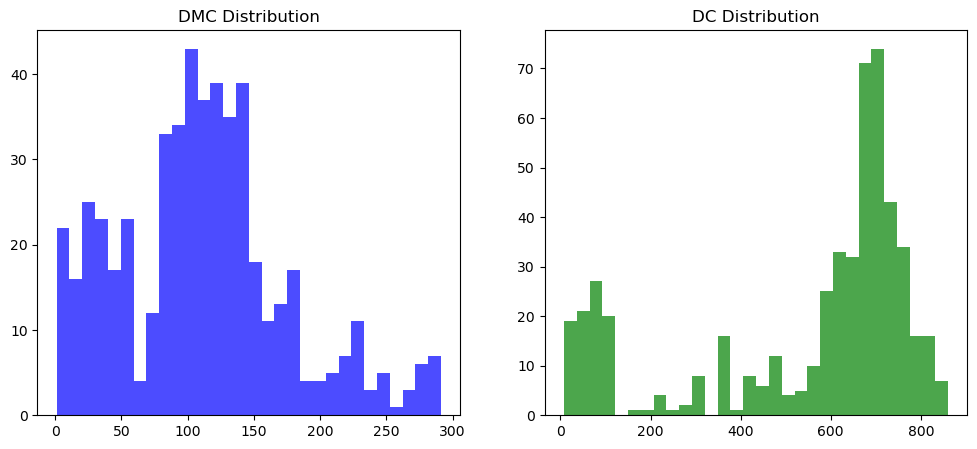

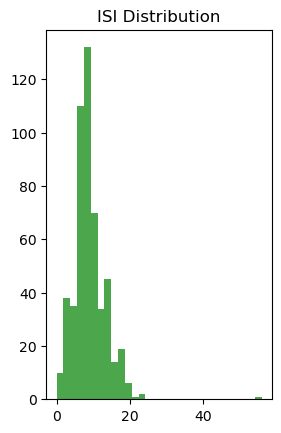

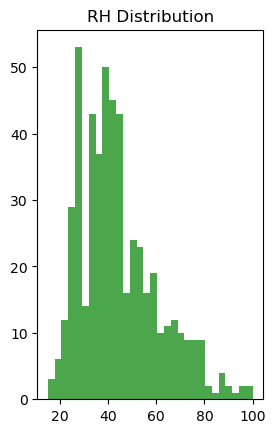

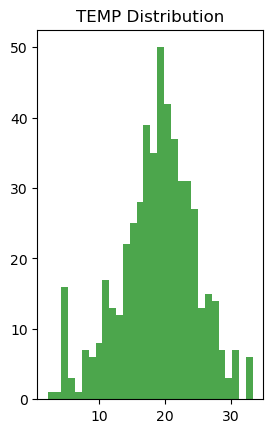

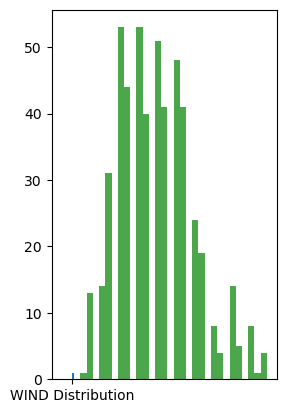

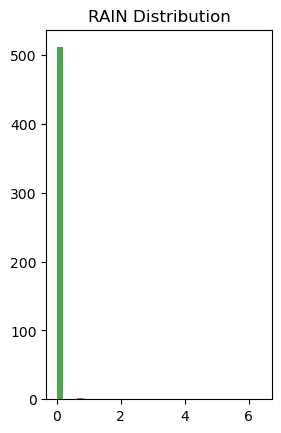

In [23]:
# Plot histograms to check skewness
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.hist(fires_dt['dmc'], bins=30, color='blue', alpha=0.7)
plt.title('DMC Distribution')

plt.subplot(1, 2, 2)
plt.hist(fires_dt['dc'], bins=30, color='green', alpha=0.7)
plt.title('DC Distribution')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(fires_dt['isi'], bins=30, color='green', alpha=0.7)
plt.title('ISI Distribution')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(fires_dt['rh'], bins=30, color='green', alpha=0.7)
plt.title('RH Distribution')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(fires_dt['temp'], bins=30, color='green', alpha=0.7)
plt.title('TEMP Distribution')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(fires_dt['wind'], bins=30, color='green', alpha=0.7)
plt.hist('WIND Distribution')
plt.show()

plt.subplot(1, 2, 2)
plt.hist(fires_dt['rain'], bins=30, color='green', alpha=0.7)
plt.title('RAIN Distribution')
plt.show()

## Model Pipeline


Create a [model pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html): 

+ Add a step labelled `preprocessing` and assign the Column Transformer from the previous section.
+ Add a step labelled `regressor` and assign a regression model to it. 

## Regressor

+ Use a regression model to perform a prediction. 

    - Choose a baseline regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Choose a more advance regressor, tune it (if necessary) using grid search, and evaluate it using cross-validation.
    - Both model choices are up to you, feel free to experiment.

In [24]:
# Pipeline A = preproc1 and baseline
# Define the baseline regressor (Random Forest Regressor)
baseline_regressor = RandomForestRegressor(random_state=42)

# Pipeline A = preproc1 and baseline
pipeline_a = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', baseline_regressor)
])
pipeline_a

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [29]:
# Pipeline B = preproc2 and baseline
pipeline_b = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', baseline_regressor)
])
pipeline_b

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scale', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('num_log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000023A23C475E0>),
                                                  ['isi', 'dc', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', RandomForestRegressor(random_state=42))])

In [26]:
# Pipeline C = preproc1 + advanced model
# Define the advanced regressor (Gradient Boosting Regressor)
advanced_regressor = GradientBoostingRegressor(random_state=42)

# Pipeline C = preproc1 + advanced model
pipeline_c = Pipeline([
    ('preprocessing', preproc1),
    ('regressor', advanced_regressor)
])
pipeline_c


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scaling',
                                                  StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('cat_encoding',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

In [28]:
# Pipeline D = preproc2 + advanced model
pipeline_d = Pipeline([
    ('preprocessing', preproc2),
    ('regressor', advanced_regressor)
])
pipeline_d
    

Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('num_scale', StandardScaler(),
                                                  ['coord_x', 'coord_y', 'ffmc',
                                                   'dmc', 'dc', 'isi', 'temp',
                                                   'rh', 'wind', 'rain']),
                                                 ('num_log',
                                                  FunctionTransformer(feature_names_out='one-to-one',
                                                                      func=<function <lambda> at 0x0000023A23C475E0>),
                                                  ['isi', 'dc', 'rain']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore'),
                                                  ['month', 'day'])])),
                ('regressor', GradientBoostingRegressor(random_state=42))])

# Tune Hyperparams

+ Perform GridSearch on each of the four pipelines. 
+ Tune at least one hyperparameter per pipeline.
+ Experiment with at least four value combinations per pipeline.

In [31]:
#Tuning for Pipeline A

# Define the parameter grid for GridSearchCV with Random Forest Regressor
param_grid_a = { 
    'regressor__n_estimators': [50, 100, 200, 300], # Number of trees in random forest
    'regressor__max_depth': [None, 10, 20, 30], # Maximum depth of trees
    'regressor__max_features': ['sqrt', 'log2', 0.5, None], # Number of features to consider at every split
    #'regressor__min_samples_split': [2, 5],         # Minimum samples required to split a node
    #'regressor__min_samples_leaf': [1, 2]           # Minimum samples at a leaf node
    }

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform GridSearchCV for Pipeline A
grid_cv_a = GridSearchCV(
    estimator=pipeline_a, 
    param_grid=param_grid_a, 
    scoring="neg_mean_squared_error", 
    cv=5,
    refit=True,
)

# Fit the model
grid_cv_a.fit(X_train, y_train)

# Get best parameters and score
best_params_a = grid_cv_a.best_params_
best_score_a = -grid_cv_a.best_score_

print("Best Parameters:", best_params_a) # Best hyperparameters
print("Best RMSE:", np.sqrt(best_score_a))

# Evaluate the model on the test set
test_score_a = grid_cv_a.score(X_test, y_test)
print("Test set score (neg_mean_squared_error) for Pipeline A: ", test_score_a)

Best Parameters: {'regressor__max_depth': None, 'regressor__max_features': 'log2', 'regressor__n_estimators': 50}
Best RMSE: 48.15903728278578
Test set score (neg_mean_squared_error) for Pipeline A:  -11903.666281163894


In [32]:
#Tuning for Pipeline B

# Define the parameter grid for GridSearchCV with Random Forest Regressor
param_grid_b = { 
    'regressor__n_estimators': [50, 100, 200, 300], # Number of trees in random forest
    'regressor__max_depth': [None, 10, 20, 30], # Maximum depth of trees
    'regressor__max_features': ['sqrt', 'log2', 0.5, None], # Number of features to consider at every split
    #'regressor__min_samples_split': [2, 5],         # Minimum samples required to split a node
    #'regressor__min_samples_leaf': [1, 2]           # Minimum samples at a leaf node
    }

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Perform GridSearchCV for Pipeline B
grid_cv_b = GridSearchCV(
    estimator=pipeline_b, 
    param_grid=param_grid_b, 
    scoring="neg_mean_squared_error", 
    cv=5,
    refit=True,
)

# Fit the model
grid_cv_b.fit(X_train, y_train)

# Get best parameters and score
best_params_b = grid_cv_b.best_params_
best_score_b = -grid_cv_b.best_score_ # Negate the score to get RMSE

print("Best Parameters:", best_params_b) # Best hyperparameters
print("Best RMSE:", np.sqrt(best_score_b))

# Evaluate the model on the test set
test_score_b = grid_cv_b.score(X_test, y_test)
print("Test set score (neg_mean_squared_error) for Pipeline B: ", test_score_b)

Best Parameters: {'regressor__max_depth': 10, 'regressor__max_features': 'log2', 'regressor__n_estimators': 200}
Best RMSE: 48.858354104679336
Test set score (neg_mean_squared_error) for Pipeline B:  -11507.815142074807


In [33]:
#Tuning for Pipeline C

# Define parameter grid for Gradient Boosting Regressor
param_grid_c = {
    'regressor__n_estimators': [50, 100, 200, 300],  # Number of boosting stages
    'regressor__learning_rate': [0.01, 0.1, 0.2],   # Learning rate shrinks contribution of each tree
    'regressor__max_depth': [3, 5, 7]               # Maximum depth of individual trees
}

# Perform GridSearchCV for Pipeline C
grid_cv_c = GridSearchCV(
    estimator=pipeline_c,
    param_grid=param_grid_c,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True
)

# Fit GridSearchCV on training data
grid_cv_c.fit(X_train, y_train)

# Get best parameters and score
best_params_c = grid_cv_c.best_params_
best_score_c = -grid_cv_c.best_score_ # Negate the Negative mean squared error to get RMSE

print("Best Parameters:", best_params_c) # Best hyperparameters
print("Best RMSE:", np.sqrt(best_score_c))

# Evaluate the model on the test set
test_score_c = grid_cv_c.score(X_test, y_test)
print("Test set score (neg_mean_squared_error) for Pipeline B: ", test_score_c)

Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best RMSE: 50.71066416297647
Test set score (neg_mean_squared_error) for Pipeline B:  -11912.6101023691


In [34]:
#Tuning for Pipeline D

# Define parameter grid for Gradient Boosting Regressor
param_grid_d = {
    'regressor__n_estimators': [50, 100, 200, 300],  # Number of boosting stages
    'regressor__learning_rate': [0.01, 0.1, 0.2],   # Learning rate shrinks contribution of each tree
    'regressor__max_depth': [3, 5, 7]               # Maximum depth of individual trees
}

# Perform GridSearchCV for Pipeline D
grid_cv_d = GridSearchCV(
    estimator=pipeline_d,
    param_grid=param_grid_d,
    scoring='neg_mean_squared_error',
    cv=5,
    refit=True
)

# Fit GridSearchCV on training data
grid_cv_d.fit(X_train, y_train)

# Get best parameters and score
best_params_d = grid_cv_d.best_params_
best_score_d = -grid_cv_d.best_score_ # Negate the Negative mean squared error to get RMSE

print("Best Parameters:", best_params_d) # Best hyperparameters
print("Best RMSE:", np.sqrt(best_score_d))

# Evaluate the model on the test set
test_score_d = grid_cv_d.score(X_test, y_test)
print("Test set score (neg_mean_squared_error) for Pipeline B: ", test_score_d)

Best Parameters: {'regressor__learning_rate': 0.01, 'regressor__max_depth': 3, 'regressor__n_estimators': 50}
Best RMSE: 50.680195388851196
Test set score (neg_mean_squared_error) for Pipeline B:  -11922.382232386582


# Evaluate

+ Which model has the best performance?

Pipeline A is the best performing pipeline due to lower RMSE (which indicates best performance).

# Export

+ Save the best performing model to a pickle file.

In [35]:
# Save the best-performing model (Pipeline A) to a pickle file
with open('best_model_pipeline_a.pkl', 'wb') as f:
    pickle.dump(grid_cv_a.best_estimator_, f)

print("Best-performing model saved as 'best_model_pipeline_a.pkl'")

Best-performing model saved as 'best_model_pipeline_a.pkl'


In [36]:
# Load the saved model for verification
with open('best_model_pipeline_a.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Verify by making predictions
predictions = loaded_model.predict(X_test)
print("Predictions on test data:", predictions[:5])

Predictions on test data: [ 9.7018      5.2554      5.0384     11.32193333 32.5124    ]


# Explain

+ Use SHAP values to explain the following only for the best-performing model:

    - Select an observation in your test set and explain which are the most important features that explain that observation's specific prediction.

    - In general, across the complete training set, which features are the most and least important.

+ If you were to remove features from the model, which ones would you remove? Why? How would you test that these features are actually enhancing model performance?

*(Answer here.)*

## Criteria

The [rubric](./assignment_2_rubric_clean.xlsx) contains the criteria for assessment.

## Submission Information

🚨 **Please review our [Assignment Submission Guide](https://github.com/UofT-DSI/onboarding/blob/main/onboarding_documents/submissions.md)** 🚨 for detailed instructions on how to format, branch, and submit your work. Following these guidelines is crucial for your submissions to be evaluated correctly.

### Submission Parameters:
* Submission Due Date: `HH:MM AM/PM - DD/MM/YYYY`
* The branch name for your repo should be: `assignment-2`
* What to submit for this assignment:
    * This Jupyter Notebook (assignment_2.ipynb) should be populated and should be the only change in your pull request.
* What the pull request link should look like for this assignment: `https://github.com/<your_github_username>/production/pull/<pr_id>`
    * Open a private window in your browser. Copy and paste the link to your pull request into the address bar. Make sure you can see your pull request properly. This helps the technical facilitator and learning support staff review your submission easily.

Checklist:
- [ ] Created a branch with the correct naming convention.
- [ ] Ensured that the repository is public.
- [ ] Reviewed the PR description guidelines and adhered to them.
- [ ] Verify that the link is accessible in a private browser window.

If you encounter any difficulties or have questions, please don't hesitate to reach out to our team via our Slack at the `help` channel. Our Technical Facilitators and Learning Support staff are here to help you navigate any challenges.

# Reference

Cortez,Paulo and Morais,Anbal. (2008). Forest Fires. UCI Machine Learning Repository. https://doi.org/10.24432/C5D88D.